# LogisticRegression

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
import time
import json
import config as cfg

from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score
)

cv_dev = StratifiedKFold(n_splits=cfg.N_SPLITS, shuffle=True, random_state=cfg.SEED)
cv_test = RepeatedStratifiedKFold(n_splits=cfg.N_SPLITS, n_repeats=cfg.N_REPEATS, random_state=cfg.SEED)

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

sns.set_context("paper", font_scale=1.4)
sns.set_style("darkgrid")

In [2]:
MODEL_NAME = 'LogisticRegression'

In [3]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_test.csv"))

X_train

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,0,"(25.67, 28.625]","(1.25, 1.934]",2,"(6.0, 8.0]",4,"(1.625, 2.625]",1,0,"(-0.001, 67.0]",0,1,"(216.0, 2000.0]","(0.999, 6.0]"
1,1,"(40.58, 48.347]","(6.0, 9.432]",2,"(3.0, 6.0]",4,"(-0.001, 0.04]",0,0,"(-0.001, 67.0]",0,2,"(-0.001, 100.0]","(6.0, 100001.0]"
2,1,"(21.734, 23.33]","(0.375, 0.75]",2,"(3.0, 6.0]",4,"(0.04, 0.165]",0,0,"(-0.001, 67.0]",1,2,"(216.0, 2000.0]","(6.0, 100001.0]"
3,1,"(35.17, 40.58]","(-0.001, 0.375]",1,"(6.0, 8.0]",4,"(1.0, 1.625]",0,0,"(-0.001, 67.0]",1,2,"(216.0, 2000.0]","(6.0, 100001.0]"
4,1,"(35.17, 40.58]","(4.016, 6.0]",2,"(6.0, 8.0]",5,"(5.085, 28.5]",1,1,"(-0.001, 67.0]",0,2,"(100.0, 216.0]","(6.0, 100001.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,1,"(48.347, 80.25]","(6.0, 9.432]",2,"(6.0, 8.0]",8,"(5.085, 28.5]",1,1,"(-0.001, 67.0]",0,2,"(100.0, 216.0]","(6.0, 100001.0]"
513,1,"(23.33, 25.67]","(2.75, 4.016]",2,"(6.0, 8.0]",4,"(1.0, 1.625]",0,1,"(-0.001, 67.0]",0,2,"(-0.001, 100.0]","(6.0, 100001.0]"
514,1,"(35.17, 40.58]","(1.25, 1.934]",2,"(6.0, 8.0]",4,"(1.0, 1.625]",1,1,"(-0.001, 67.0]",0,2,"(100.0, 216.0]","(6.0, 100001.0]"
515,1,"(40.58, 48.347]","(-0.001, 0.375]",1,"(6.0, 8.0]",4,"(0.165, 0.5]",1,1,"(-0.001, 67.0]",1,2,"(216.0, 2000.0]","(6.0, 100001.0]"


### Test performance

test_gini:	 0.8994
test_ap:	 0.9623


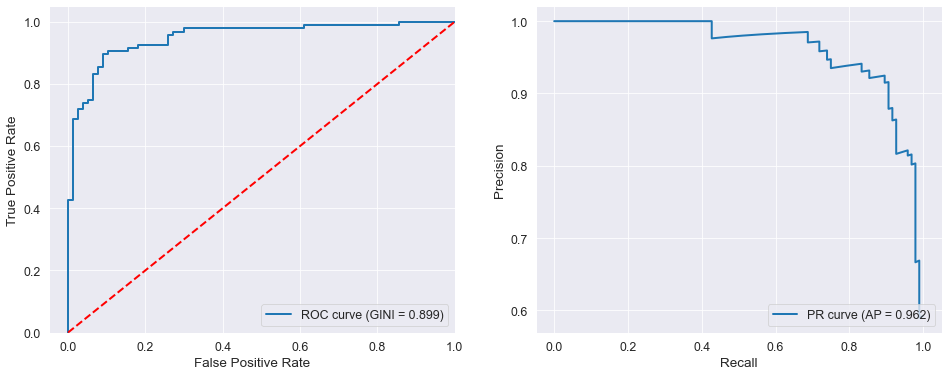

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=cfg.SEED))])
model.fit(X = X_train, y = np.ravel(y_train))

# Calculate metrics
preds = model.predict_proba(X_test)[::,1]
test_gini = metrics.roc_auc_score(y_test, preds)*2-1
test_ap = metrics.average_precision_score(y_test, preds)
print(f"test_gini:\t {test_gini:.4}")
print(f"test_ap:\t {test_ap:.4}")

# ROC
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[0].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % test_gini)
axs[0].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, preds)
lw = 2
axs[1].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % test_ap)
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(loc="lower right")

plt.savefig(os.path.join("Graphs", f"ROC_PRC_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [5]:
# Cross-validation GINI
scores_gini = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv_test, return_train_score=True, n_jobs=-1
)

mean_train_gini = (scores_gini["train_score"]*2-1).mean()
mean_test_gini = (scores_gini["test_score"]*2-1).mean()
std_test_gini = (scores_gini["test_score"]*2-1).std()

print(f"mean_train_gini:\t {mean_train_gini:.4}")
print(f"mean_dev_gini:\t\t {mean_test_gini:.4} (+-{std_test_gini:.1})")

mean_train_gini:	 0.8743
mean_dev_gini:		 0.836 (+-0.06)


### Model analysis

BAD    0.524691
dtype: float64


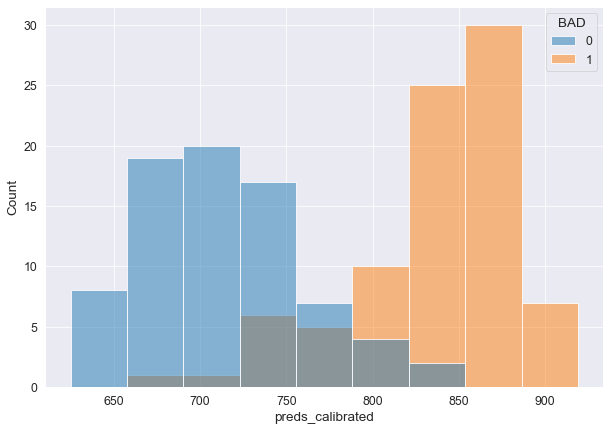

In [6]:
rus = RandomUnderSampler(sampling_strategy=cfg.SAMPLING_STRATEGY)
X_sub, y_sub = rus.fit_resample(X_test, y_test)
print(y_sub.mean())

preds = model.predict_proba(X_sub)[::,1]
preds_calibrated = pd.DataFrame(np.round(28.85*np.log(preds/(1-preds))+765.75), columns=["preds_calibrated"])

fig, axs = plt.subplots(1, 1, figsize=(10,7))
palette ={0: "C0", 1: "C1"}
sns.histplot(data=preds_calibrated, x="preds_calibrated", hue=y_sub['BAD'], palette=palette, ax=axs, bins='auto')

plt.savefig(os.path.join("Graphs", f"Score_distr_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [7]:
# Logistic regression coefficients
coefs = pd.DataFrame(
    zip(X_train.columns, model["lr"].coef_[0]), columns=["Variable", "Coef"]
)
coefs_sorted = coefs.reindex(coefs["Coef"].abs().sort_values(ascending=False).index)
coefs_sorted

,Variable,Coef
7,A8,-2.831339
4,A5,0.781223
3,A4,-0.776461
8,A9,-0.721454
11,A12,-0.702570
12,A13,0.690980
2,A3,0.687476
13,A14,0.531908
1,A2,0.436689
6,A7,0.429369


In [8]:
# Save results for final summary
results = {
    "test_gini": test_gini,
    "test_ap": test_ap,
    "optimization_time": 0,
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "precision": precision.tolist(),
    "recall": recall.tolist(),
    "mean_train_gini": scores_gini["train_score"].tolist(),
    "mean_test_gini": scores_gini["test_score"].tolist(),
}

with open(os.path.join("Results", f"Results_{MODEL_NAME}.json"), 'w') as fp:
    json.dump(results, fp)